<a href="https://colab.research.google.com/github/eldor-fozilov/analyzing-the-stability-of-portfolio-allocation-methods-using-CorrGAN/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#pip install fastcluster
#!pip install riskfolio-lib

In [1]:
import riskfolio as rp

In [2]:
%matplotlib inline

import os
import glob
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from statsmodels.stats.correlation_tools import corr_nearest
from tqdm import tqdm

from IPython import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Upload Model

In [4]:
model_path = 'drive/MyDrive/interdisciplinary_project/generator_50d'

In [5]:
model = tf.keras.models.load_model(model_path)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6400)              640000    
                                                                 
 batch_normalization (BatchN  (None, 6400)             25600     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6400)              0         
                                                                 
 reshape (Reshape)           (None, 5, 5, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      294912    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 128)      5

## Generate Correlation Matrices Using CorrGAN

In [8]:
n = 50
a, b = np.triu_indices(n, k=1)

In [ ]:
MAX_COUNT = 1000

correl_mats = []
for count in range(MAX_COUNT):
    print(count)

    noise = tf.random.normal([1, 100])
    generated_image = model.predict_generator(noise)

    correls = np.array(generated_image[0,:,:,0])
    # set diag to 1
    np.fill_diagonal(correls, 1)
    # symmetrize
    correls[b, a] = correls[a, b]
    # nearest corr
    nearest_correls = corr_nearest(correls)
    # set diag to 1
    np.fill_diagonal(nearest_correls, 1)
    # symmetrize
    nearest_correls[b, a] = nearest_correls[a, b]
    
    dist = 1 - nearest_correls
    Z = fastcluster.linkage(dist[a, b], method='ward')
    permutation = hierarchy.leaves_list(
        hierarchy.optimal_leaf_ordering(Z, dist[a, b]))
    prows = nearest_correls[permutation, :]
    ordered_corr = prows[:, permutation]
    
    correl_mats.append(ordered_corr)

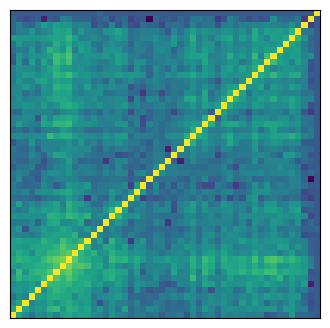

In [13]:
plt.figure(figsize=(4, 4))
plt.pcolormesh(ordered_corr)

plt.tick_params(
    axis='both',        
    which='both',
    bottom=False,  
    top=False,     
    left= False,
    labelbottom=False,
    labelleft=False)

#plt.savefig('gan_matrices/correl_{}.png'.format(count),
 #           bbox_inches='tight',
  #          transparent=True)

plt.plot()
plt.show()

# Portfolio Allocation Methods

In [14]:
def compute_MV_weights(covariances):
    inv_covar = np.linalg.inv(covariances)
    u = np.ones(len(covariances))
    
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))


def compute_IV_weights(covariances):
    weights = (1 / np.diag(covariances)) 
    
    return weights / sum(weights)


def compute_unif_weights(covariances):
    
    return [1 / len(covariances) for i in range(len(covariances))]


def compute_ERC(cov,**kargs):
    # Compute ERC portfolio from "A Fast Algorithm for Computing High-dimensional Risk Parity Portfolios"
 
      cov = np.array(cov)
      n = np.shape(cov)[0]
 
      x0 = np.ones((n,1)) / n
      x = x0*10
      var = np.diag(cov)
      Sx = cov.dot(x)
      cvg = False
 
      while not cvg:
          for i in range(n):
              alpha = var[i];
              beta =  (Sx[i]-x[i]*var[i])[0];
 
              gamma_ = -1.0/n;
 
              x_tilde = (-beta + np.sqrt(beta**2 - 4*alpha*gamma_)) / (2*alpha);
              x_i = x[i];
 
              x[i] = x_tilde;
              Sx = cov.dot(x) 
 
          cvg = np.sum( (x/np.sum(x) - x0/np.sum(x0))**2 ) <= 1e-8;
          #print cvg
          x0 = x.copy()
 
      return np.array(x/x.sum()).ravel()


def compute_HRP_weights(returns):
# Building the portfolio object
  port = rp.HCPortfolio(returns=returns)

# Estimate optimal portfolio:

  model = 'HRP' # Could be HRP, HERC or NCO
  codependence = 'pearson' # Correlation matrix used to group assets in clusters
  rm = 'MV' # Risk measure used, this time will be variance
  rf = 0 # Risk free rate
  linkage = 'ward' # Linkage method used to build clusters
  max_k = 10 # Max number of clusters used in two difference gap statistic
  leaf_order = True # Consider optimal order of leafs in dendrogram

  w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
  
  return w.values.reshape(-1)



def compute_HERC_weights(returns):
# Building the portfolio object
  port = rp.HCPortfolio(returns=returns)

# Estimate optimal portfolio:

  model = 'HERC' # Could be HRP, HERC or NCO
  codependence = 'pearson' # Correlation matrix used to group assets in clusters
  rm = 'MV' # Risk measure used, this time will be variance
  rf = 0 # Risk free rate
  linkage = 'ward' # Linkage method used to build clusters
  max_k = 10 # Max number of clusters used in two difference gap statistic
  leaf_order = True # Consider optimal order of leafs in dendrogram

  w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
  return w.values.reshape(-1)

# Statistics in- and out-sample: portfolio volatility

In [15]:
from scipy.stats import t

In [42]:
def compute_portfolio_volatility(weights, returns):
    return ((weights * returns)
            .sum(axis=1)
            .std() * np.sqrt(252))

def generate_returns_sample_with_shock(covariances, dof = 4, horizon=252):
    stock_returns = np.random.multivariate_normal(
        np.zeros(len(covariances)), covariances,
        size=horizon).T
    df = 4  # Degrees of freedom for t-distribution
    # Loop over each time series and add t-distribution shocks
    for i in range(0,stock_returns.shape[0]):
      shocks = t.rvs(df = dof, scale = stock_returns[i].std(), size=stock_returns.shape[1])
      for j in range(len(shocks)):
        if abs(shocks[j]) <= 3*stock_returns[i].std() and abs(shocks[j]) >= 6*stock_returns[i].std():
          shocks[j] = 0
      stock_returns[i] += shocks

    return pd.DataFrame(stock_returns.T)

def generate_returns_sample_without_shock(covariances, horizon=252):
    stock_returns = np.random.multivariate_normal(
        np.zeros(len(covariances)), covariances,
        size=horizon)

    return pd.DataFrame(stock_returns)

In [43]:
cov_param = correl_mats[0]

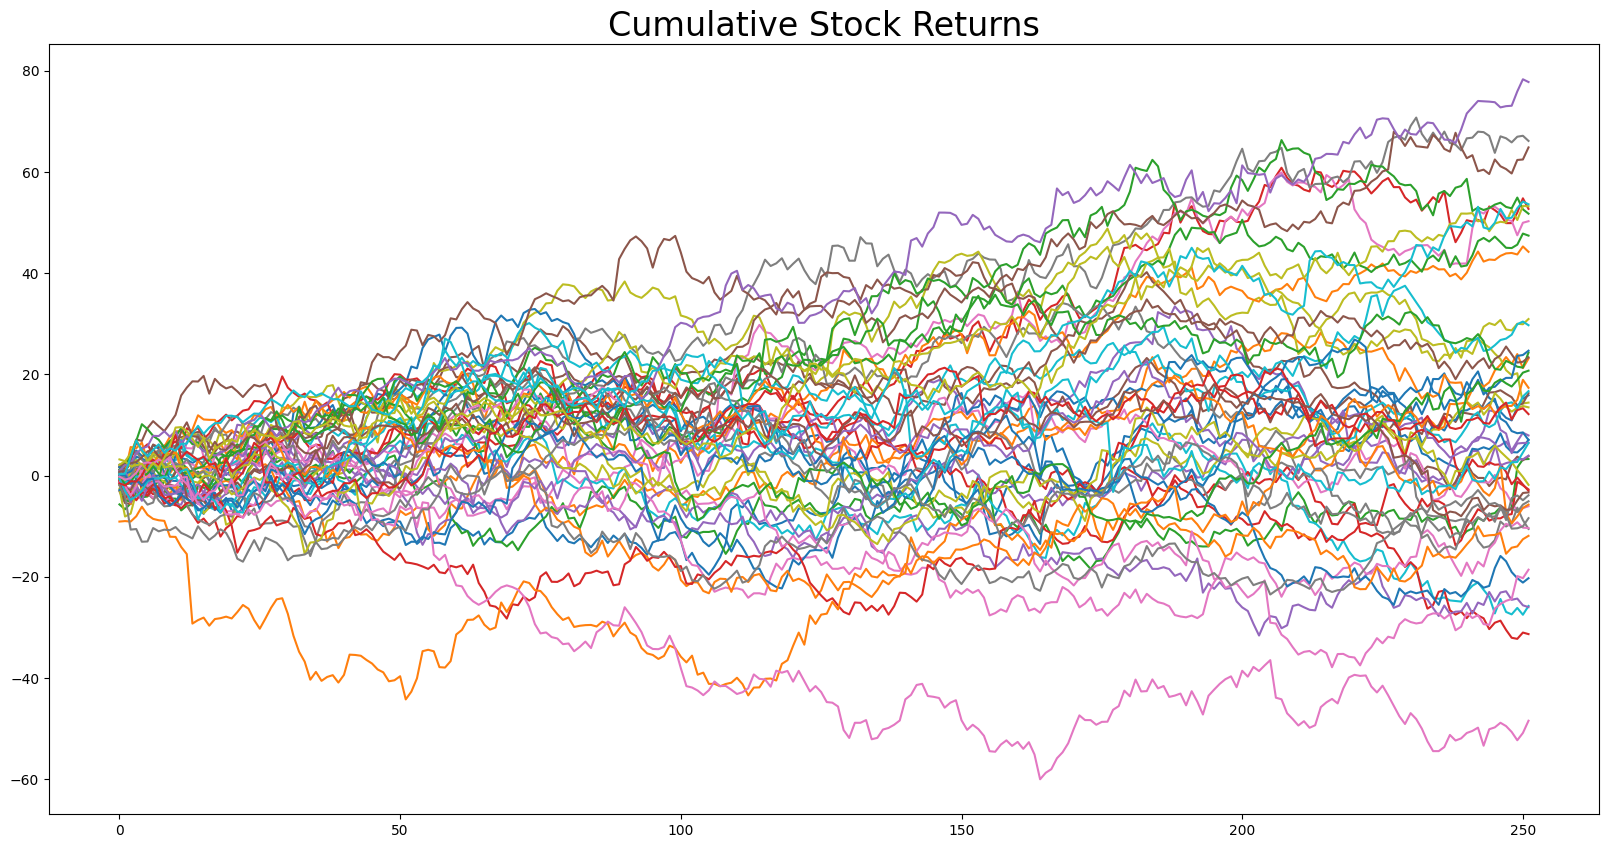

In [44]:
returns = generate_returns_sample_with_shock(cov_param)
plt.figure(figsize=(20, 10))
plt.plot(returns.cumsum())
plt.title('Cumulative Stock Returns', fontsize=24)
plt.show()

In [20]:
methods = {
    'Minimum Variance': compute_MV_weights,
    'Inverse Variance': compute_IV_weights,
    'Equal Weighting': compute_unif_weights,
    'Equal Risk Contribution': compute_ERC,
    'Hierarchical Risk Parity': compute_HRP_weights,
    'Hierarchical Equal Risk Contribution': compute_HERC_weights
}

## Experiment with Generated Data from The Normal Distribution with Shocks

In [21]:
empirical_volatilities = {method: {'in-sample' : [], 'out-sample': []}
                          for method in methods.keys()}

nb_experiments = 1000
idx = 0
for experiment in tqdm(range(nb_experiments)):
    true_covariances = correl_mats[idx]
    in_sample = generate_returns_sample_with_shock(
        true_covariances, horizon=3 * 252)
    out_sample = generate_returns_sample_with_shock(
        true_covariances, horizon=3 * 252)
    
    for name, method in methods.items():
      if name in ['Hierarchical Risk Parity','Hierarchical Equal Risk Contribution']:
        in_sample_weights = method(in_sample)
      else:
        in_sample_weights = method(in_sample.cov().values)

      in_sample_vol = compute_portfolio_volatility(
          in_sample_weights, in_sample)
      
      out_sample_vol = compute_portfolio_volatility(
          in_sample_weights, out_sample)

      empirical_volatilities[name][
          'in-sample'].append(in_sample_vol)
      empirical_volatilities[name][
          'out-sample'].append(out_sample_vol)

    idx += 1

100%|██████████| 1000/1000 [1:13:15<00:00,  4.40s/it]


Method: Minimum Variance
In-sample variance: 7.6222
Out-sample variance: 8.1949


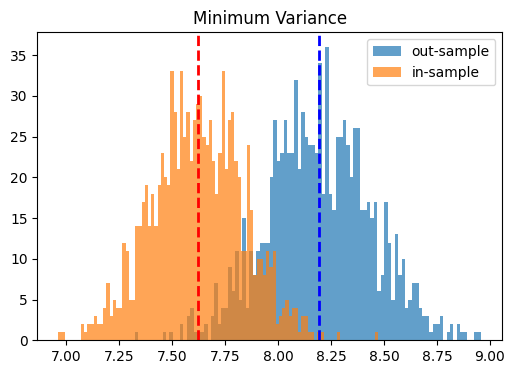

Method: Inverse Variance
In-sample variance: 9.2616
Out-sample variance: 9.2919


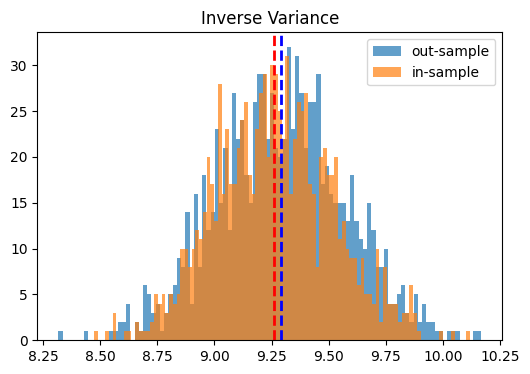

Method: Equal Weighting
In-sample variance: 9.2975
Out-sample variance: 9.2843


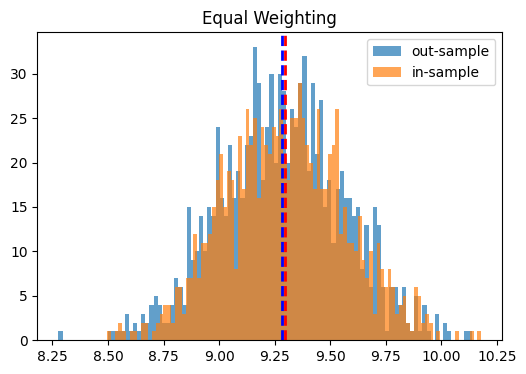

Method: Equal Risk Contribution
In-sample variance: 8.7502
Out-sample variance: 8.8304


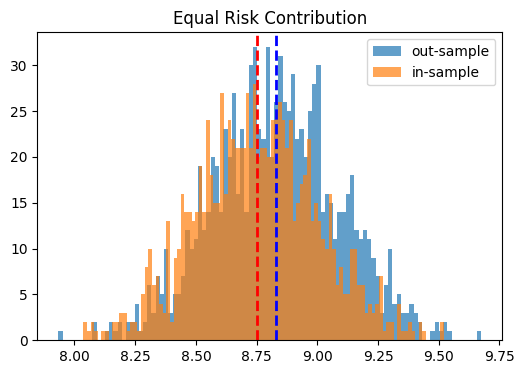

Method: Hierarchical Risk Parity
In-sample variance: 8.9879
Out-sample variance: 9.0536


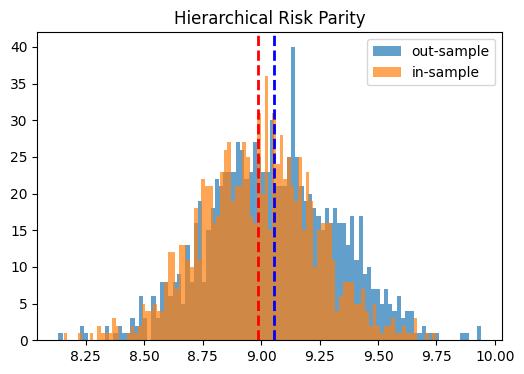

Method: Hierarchical Equal Risk Contribution
In-sample variance: 10.0975
Out-sample variance: 10.0775


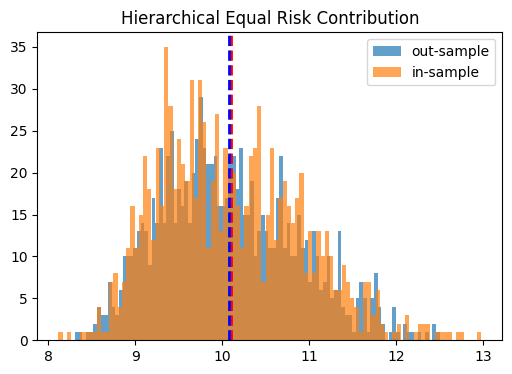

In [22]:
for method, distribs in empirical_volatilities.items():
    plt.figure(figsize = (6,4))
    print(f'Method: {method}')
    print(f"In-sample variance: {round(np.mean(distribs['in-sample']), 4)}")
    print(f"Out-sample variance: {round(np.mean(distribs['out-sample']), 4)}")

    plt.hist(distribs['out-sample'], bins=100, label='out-sample', alpha=0.7)
    plt.hist(distribs['in-sample'], bins=100, label='in-sample', alpha=0.7)
    plt.axvline(x=np.mean(distribs['in-sample']), color='r',
                linestyle='dashed', linewidth=2)
    plt.axvline(x=np.mean(distribs['out-sample']), color='b',
                linestyle='dashed', linewidth=2)
    plt.title(method)
    plt.legend(loc=1)
    plt.show()

## Experiment with Generated Data from The Normal Distribution without Shocks

In [34]:
empirical_volatilities_without_shock = {method: {'in-sample' : [], 'out-sample': []}
                          for method in methods.keys()}

nb_experiments = 1000
idx = 0
for experiment in tqdm(range(nb_experiments)):
    true_covariances = correl_mats[idx]
    in_sample = generate_returns_sample_without_shock(
        true_covariances, horizon=3 * 252)
    out_sample = generate_returns_sample_without_shock(
        true_covariances, horizon=3 * 252)
    
    for name, method in methods.items():
      if name in ['Hierarchical Risk Parity','Hierarchical Equal Risk Contribution']:
        in_sample_weights = method(in_sample)
      else:
        in_sample_weights = method(in_sample.cov().values)

      in_sample_vol = compute_portfolio_volatility(
          in_sample_weights, in_sample)
      
      out_sample_vol = compute_portfolio_volatility(
          in_sample_weights, out_sample)

      empirical_volatilities_without_shock[name][
          'in-sample'].append(in_sample_vol)
      empirical_volatilities_without_shock[name][
          'out-sample'].append(out_sample_vol)

    idx += 1

100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]


Method: Minimum Variance
In-sample variance: 0.0
Out-sample variance: 0.0


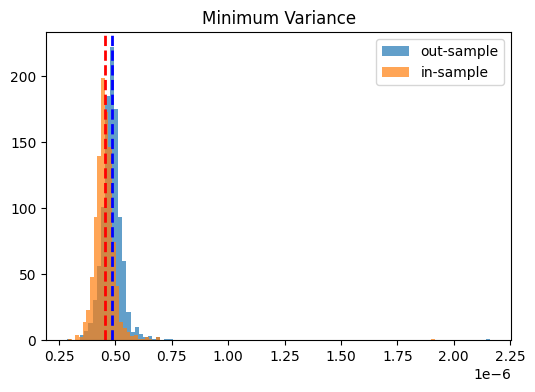

Method: Inverse Variance
In-sample variance: 8.7213
Out-sample variance: 8.7486


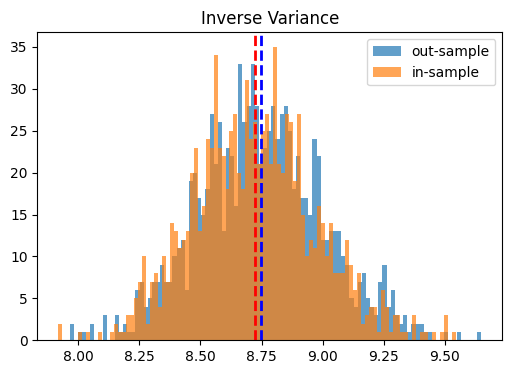

Method: Equal Weighting
In-sample variance: 8.7367
Out-sample variance: 8.7486


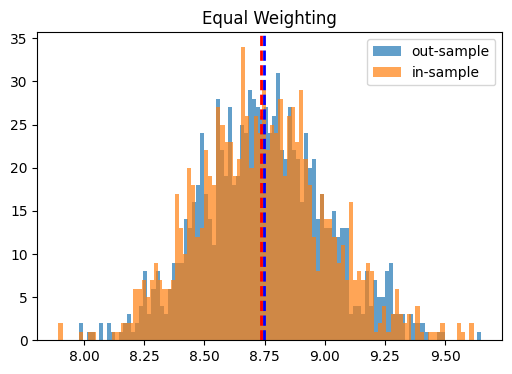

Method: Equal Risk Contribution
In-sample variance: 7.9758
Out-sample variance: 8.0177


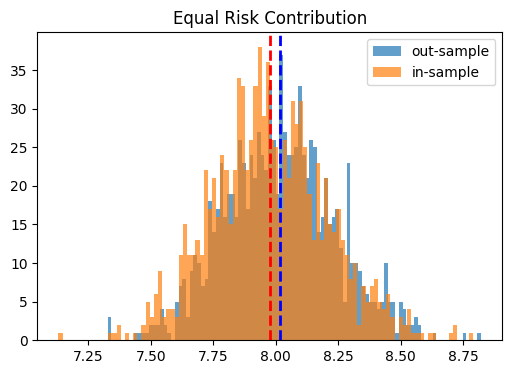

Method: Hierarchical Risk Parity
In-sample variance: 8.1698
Out-sample variance: 8.2147


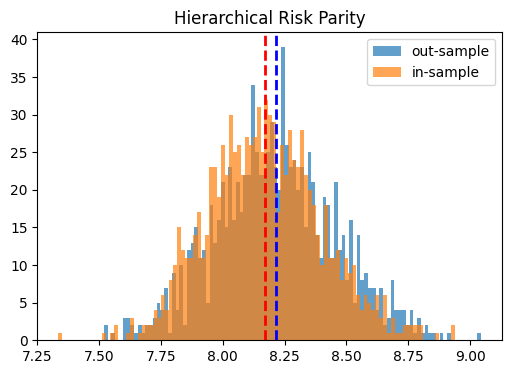

Method: Hierarchical Equal Risk Contribution
In-sample variance: 9.4135
Out-sample variance: 9.4283


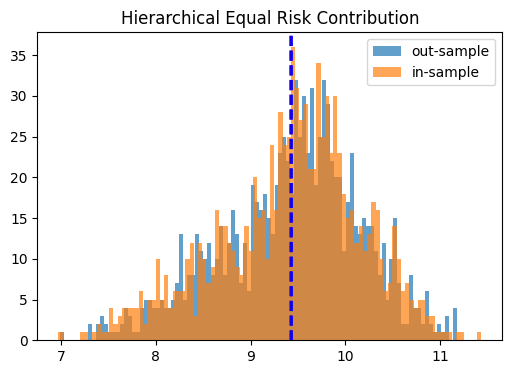

In [35]:
for method, distribs in empirical_volatilities_without_shock.items():
    plt.figure(figsize = (6,4))
    print(f'Method: {method}')
    print(f"In-sample variance: {round(np.mean(distribs['in-sample']), 4)}")
    print(f"Out-sample variance: {round(np.mean(distribs['out-sample']), 4)}")

    plt.hist(distribs['out-sample'], bins=100, label='out-sample', alpha=0.7)
    plt.hist(distribs['in-sample'], bins=100, label='in-sample', alpha=0.7)
    plt.axvline(x=np.mean(distribs['in-sample']), color='r',
                linestyle='dashed', linewidth=2)
    plt.axvline(x=np.mean(distribs['out-sample']), color='b',
                linestyle='dashed', linewidth=2)
    plt.title(method)
    plt.legend(loc=1)
    plt.show()